# Particle Filter for Indoor Positioning using IMU Measurements
In this assignment, you will implement the particle filter (PF) framework that incorporates IMU measurements in the motion model and a given map to determine the locations of a moving person in indoor environments. Unlike the general PF introduced in the class, there is no observation from other sensing modalities. As such, state updates are the results of motions and all particles that *fall within the confinement of the corridors are assumed to have (non-zero) equal probabilities*.

- The <font color="blue">pdr.py</font> file provided contains a number of useful functions for step counting, heading estimation from acc-mag readings and heading change estimation from gyro. The first two were essentially what you implemented from the previous homework. Take a look at the code before you start the project. To use it, put it in the local directory where your code runs.

In [1]:
import numpy as np
import ianus
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import matplotlib.cm as cmx
import warnings
import pdr 
import math

## 1. Read map data
In the dataset, map data is defined in OSM format, which represents a cooridoor as multipolygon (one enclosed outer polygon, and a number of inner polygons). OSM represents map data in XML. 
More details on OSM format can be found at http://wiki.openstreetmap.org/wiki/OSM_XML. <a href="https://josm.openstreetmap.de">JOSM</a> is a Java based tool to manipulate OSM files. Basic parsing of OSM in python can be found at https://github.com/dezhin/osmread/tree/master/osmread

In [2]:
def contain_point(pos, multipolygon):
    """
    Test if a 2D point is within the boundaries of multi-polygon.
    Inputs: 
        - pos: 1-D array 
        - multipolygon: a dictionary contains the outer and inner boundaries of a multi-polygon
    """
    if multipolygon['outer'].contains_point(pos) == False:
        return False

    for w in multipolygon['inner']:
        if w.contains_point(pos):
            return False
    
    return True

def contain_points(pts, multipolygon):
    """
    Test if multiple points are within the boundaries of multi-polygon.
    Inputs: 
        - pts: Nx2 array of N points
        - multipolygon: a dictionary contains the outer and inner boundaries of a multi-polygon
    """
    
    y = []
    for i in range(pts.shape[0]):
        y.append(contain_point(pts[i,:], multipolygon))
    return y

def plot_multipolygon(ax, multipolygon, markers=None):
    """Plot a multipolygon. Pass as the first argument the handle of the figure 
    """

    p = multipolygon['outer']
    xy_lim = np.array([p.vertices.min(axis=0) - 2, p.vertices.max(axis=0) + 2])
    ax.set_xlim(xy_lim[0, 0], xy_lim[1, 0])
    ax.set_ylim(xy_lim[0, 1], xy_lim[1, 1])

    patch = patches.PathPatch(p, facecolor='orange', lw=2)
    ax.add_patch(patch)

    for w in multipolygon['inner']:
        patch = patches.PathPatch(w, facecolor='white', lw=2)
        ax.add_patch(patch)

    if markers is not None:
        for m in markers:
            for key, value in markers.items():
                ax.plot(value[0], value[1], 'b.')

### Read and display the floor plan and makers location
- <font color="blue">read_osm_data</font> returns the nodes/vertices, pathways/edges, marker locations and a dict structure called multipolygon,
which specifies the boundary of the corridor. A multi-polygon has a single outer boundary and multiple inner boundaries. 

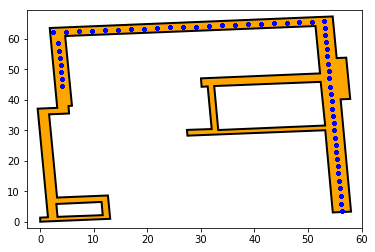

In [3]:
datapath = './dataset/'
origin = [43.2584319, -79.9213713] # coordinates of (0,0) in our map

nodes, markers, ways, multipolygon = ianus.reader.read_osm_data(datapath + 'map.osm', origin)
fig=plt.figure('1')
ax = fig.add_subplot(111)
plot_multipolygon(ax, multipolygon, markers)
plt.show()


## 2. Read sensor data
- X_raw_acc: accelerometer data sampled at 100Hz. Nx4 matrix, where N is the # of samples, each row is of [timestamp in ms, acc_x, acc_y, acc_z]
- X_raw_mag: magnetic data sampled at 100Hz. Nx4 matrix, where N is the # of samples, each row is of [timestamp in ms, mag_x, mag_y, mag_z]
- X_raw_gyro: accelerometer data sampled at 100Hz. Nx4 matrix, where N is the # of samples, each row is of [timestamp in ms, gyro_x, gyro_y, gyro_z]
- Y: ground truth locations. Mx3 matrix, where M is the number of marker locations, each row is of [timestamp in ms, x_coor, y_coor]

**Note all sensor data are in device frame**

In [44]:
X_raw = ianus.reader.read_imu_data(datapath+'imu.pbf')
X_raw_acc = np.array(X_raw['acc'])
X_raw_mag = np.array(X_raw['mag'])
X_raw_gyro = np.array(X_raw['gyro'])

Y = np.zeros((len(markers), 3))
Y[:,0] = np.array(ianus.reader.read_marker_data(datapath+'marker.pbf'))[:,0]
for key, value in markers.items():
    Y[int(key)-1,1:4] = value
#print("Y", Y)
#print("type of Y", type(Y))
#print("shape of Y", Y.shape)
timeinterval = Y[54,0]-Y[0,0]
#print("timeinterval", timeinterval)
    
# sampling frequency
fs = 100
fc = 4.4 ####how to choose cut-off freq
acc = np.transpose(np.array([X_raw_acc[:,1],X_raw_acc[:,2],X_raw_acc[:,3]]))
#print("acc.shape", acc.shape)
#print("type of X_raw_acc", type(X_raw_acc))

## 3. Step detection
Use <font color="blue">pdr.count_step(...)</font> for step counting. Vary the arguments and see the results. The data is collected from a person with light steps. Over the course of the data collection, 203 steps were made. 

In [45]:
idx,acc_lpf,acc_mag = pdr.count_step(acc, fs, fc, thres=0.21) #YOUR CODE. 1-line

print('Number of steps detected: %d' % idx.shape)

idx = np.append([0],idx) #add the starting point
#print("idx",idx)

plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(X_raw_acc[:,0], acc_lpf,'r-')
plt.plot(X_raw_acc[idx,0], acc_lpf[idx],'bx')
plt.xlim((X_raw_acc[0,0], X_raw_acc[4000,0]))
plt.xlabel('Time (ms)')
plt.ylabel('Filtered Acc Mag')
plt.show()

Number of steps detected: 203


# 4. Heading Estimation
We implement a complementary filter for heading estimation. In this experiment, we assume that device y-axis is aligned with the heading direction. Recall that there are two parts in the complementary filter: 1) heading estimation using accelerometer and magnometer readings, and 2) heading using gyro assuming the initial heading is known. 
- In <font color="blue">pdr.py</font>, we have provided three functions that you can use: EstimatePoseChangeFromGyro, EstimateHeadingAccMag, fuseTwoHeadingsXY. 
- **Implement the complementary filter** by combining the estimate from gyro and the estimate from magnetnometer and accelerometer readigns. 

You can assume the initial heading is known to be [0,1,0] in the global frame. 

In [46]:
def ComplementaryFilter(init, acc, gyro, mag, interval, weight=0.9):
    """
    Complementary filter for heading estimation
    Inputs:
        - init: 1-D array for initial heading; if None, use the one computed from acc & mag as initial
        - acc, gyro, mag: Nx3 matrices for accelerometer, gyro and magnetnometer readings
        - interval: sampling interval  (=1/fs)
        - weight: the weight for the heading inferred by gyro and (1-weight) for heading inferred by acc-mag.
    
    Output:
        - headings: Nx3 vector for heading direction 
    """

    #YOUR CODE
    num_samples = X_raw_acc.shape[0]
    headings = np.zeros((num_samples,3))
    headings[0,:] = init
    for i in range(1, num_samples):
        gyrRotation = pdr.EstimatePoseChangeFromGyro(gyro[i,:], interval)
        #gyrHeadings = headings[i-1,:] + np.dot(gyrRotation,np.array([0, 1, 0]).reshape(3,1))
        #gyrHeadings = np.dot(gyrRotation,np.array([0, 1, 0]).reshape(3,1))
        #gyrRotation = np.delete(gyrRotation, 2)
        gyrHeadings = np.dot(gyrRotation,headings[i-1,:].reshape(3,1))
        accHeadings = pdr.EstimateHeadingAccMag(acc[i,:], mag[i,:])
        #accHeadings = np.delete(accHeadings, 2)
        headings[i,:] = pdr.fuseTwoHeadingsXY(gyrHeadings, accHeadings, weight)  
    return headings



### Compute and illustrate the headings
- Call ComplementaryFilter
- Illustrate the heading estimation in 2D. Start from marker '1'. Assume every sampling interval, the displacement is 0.5/fs m (this is purely for illustration purpose). 
- With proper weight parameters, the trajectory should be of the similar curve at the blue markers displayed in the floor plan

**Note: the magnetometer reading is not calibrated in the dataset. It is expected that setting weight to be less 1 will result in large errors in  heading estimation. For final evaluation of the particle filter, the suggested value for the weight is 1. To verify the correctness of your implementation complementary filter, it is sufficient to demonstrate the effects of different weights.**

In [48]:
weight = 1
init = [0,1,0]
interval = 1/fs
gyro = np.transpose(np.array([X_raw_gyro[:,1],X_raw_gyro[:,2],X_raw_gyro[:,3]]))
mag = np.transpose(np.array([X_raw_mag[:,1],X_raw_mag[:,2],X_raw_mag[:,3]]))
headings = ComplementaryFilter(init, acc, gyro, mag, interval, weight)#YOUR CODE 1-line using ComplementaryFilter

num_samples = X_raw_acc.shape[0]
disp = 1.5/fs #meter

loc = np.zeros((num_samples, 3))
loc[0,:] = np.append(markers['1'], [0])

for i in range(1, num_samples):
    loc[i,:] = loc[i-1,:] + disp*headings[i,:]

plt.close("all")
fig = plt.figure(2)
plt.plot(loc[:,0], loc[:,1], 'r.')
plt.plot(loc[0,0], loc[0,1], 'b*')
plt.show()

## 5. Implement a Particle Filter class
We wrap particle filter as a class. You need to complete its methods. 
- Assume the initial position is at marker '1'
- All time stamps are in ms

In [173]:
# a particle filter for 2D 

class ParticleFilter2D :
    """
    Initialize particle filter
    Inputs: 
        - init_location: in 2D
        - num_particles: max number of particles
        - thres: resample threshold. If the total number of particles fall below num_particles*thres, resample
        - s: seed
    Output:
        None
    """
    def __init__(self, init_location, num_particles, mpolygon, thres = 0.5, s=0):
    
        self.N = num_particles
        self.x = np.zeros(num_particles) + init_location[0]
        self.y = np.zeros(num_particles) + init_location[1]
        self.w = np.zeros(num_particles) + 1/self.N
        self.thres = thres * num_particles #thres number: 1000
        self.map = mpolygon
        self.num = num_particles
        np.random.seed(s) #generate same random number by using the same seed
        int(self.N)
        """
        self.N = 0
        self.x = []
        self.y = []
        self.w = []
        self.thres = thres * num_particles #thres number: 1000
        self.map = mpolygon
        self.num = num_particles
        np.random.seed(s) #generate same random number by using the same seed
        int(self.N)
        exitFlag = True
        while exitFlag:
            x = np.random.uniform(0,60)
            y = np.random.uniform(0,70)
            if contain_point([x,y], self.map):
                self.x = np.append(self.x, x)
                self.y = np.append(self.y, y)
                self.N += 1
            if self.N == self.num:
                self.w = np.zeros(self.num) + 1/self.N
                exitFlag = False
        print("random initialize")
        """

    """
    Prediction step
    Inputs:
        - dp: mean displayment in x, y (meter)
        - dp_sigma: standard deviation of displament. The displacement is Gaussian distributed N(dp, dp_sigma)
        - heading: 1-D array of heading in global frame
        - heading_sigma: standard deviation of heading angle in radian. The heading direction can be uniformly sampled 
          from heading_sigma clock-wise and counter-clock-wise the angle according to the heading vector
    Output:
        None
    """

    def predict(self, dp, dp_sigma, heading, heading_sigma):
        int(self.N)
        for i in range (0, self.N):
            dp = np.random.normal(dp, dp_sigma)
            theta = np.arccos(heading[0]) + np.random.uniform(-heading_sigma, heading_sigma)
            #heading_x = heading[0] + np.random.uniform(-heading_sigma/2, heading_sigma/2)
            #heading_y = heading[1] + np.random.uniform(-heading_sigma/2, heading_sigma/2)
            self.x[i] += dp*np.cos(theta)
            self.y[i] += dp*np.sin(theta)
        
    """
    Update step: if a particle is outside of the corridor, set its weights to zero. Normalize the weights so that the
    sum weight is one. Resample if the number of particles drops below max number of particles x thres 
    """
    def update(self):
        index = []
        self.N = int(self.N)
        for i in range (0, self.N):
            if contain_point([self.x[i],self.y[i]], self.map):
                self.w[i] = 1
            else:
                self.w[i] = 0
                index = np.append(index, i)   
                
        """
        loc = np.reshape([self.x, self.y], (self.N, 2))
        index = contain_points(loc,self.map)
        """
        self.x = np.delete(self.x, index)
        self.y = np.delete(self.y, index)
        self.w = np.delete(self.w, index)
        self.N = len(self.x)
        #self.w = np.divide(self.w, self.N) #normailize
        self.w = self.w/self.N
        #print("self.N before resample", self.N)
        
        if self.N == 0:
            self.reinitialize()
        elif self.N > 0 and self.N < self.thres:
            self.resample()
             
    """
    Resample: regenerate particles according to the weights and multinomial distribution. If no particle left, 
    reinitialize.
    """
    def resample(self):
        #for i in range (0, self.thres*2):
            #self.x[i] = np.mean(pf.x)
            #self.y[i] = np.mean(pf.y)
        #self.x = np.full((self.thres*2,1),np.mean(pf.x))
        #self.y = np.full((self.thres*2,1),np.mean(pf.y))
        #self.x = np.zeros(self.thres*2)+np.mean(self.x)
        #self.y = np.zeros(self.thres*2)+np.mean(self.y)
        #self.w = np.zeros(self.thres*2)+1
        n = np.random.multinomial(self.num, self.w)
        #print("length of n", n.shape[0])
        #print("n", n)
        x_rsp = []
        y_rsp = []
        for i in range(0, n.shape[0]):
            for j in range(0, n[i]):
                x_rsp = np.append(x_rsp, self.x[i])
                y_rsp = np.append(y_rsp, self.y[i])
        #print("type of x_rsp", type(x_rsp))
        #print("length of x_rsp", len(x_rsp))
        #print("x_rsp", x_rsp)
        self.x = x_rsp
        self.y = y_rsp
        #print("length of self.x", len(self.x))
        #print("length of self.y", len(self.y))
        self.N = self.num
        self.w = np.zeros(self.num) + 1/self.N
        #print("resample")
    """
    Reinitalize: randomly initalize max # of particles to be evently distributed in the corridor. 
    This is used either when you do not know the initial location or all particles die. 
    """
    def reinitialize(self):
        exitFlag = True
        while exitFlag:
            x = np.random.uniform(0,60)
            y = np.random.uniform(0,70)
            if contain_point([x,y], self.map):
                self.x = np.append(self.x, x)
                self.y = np.append(self.y, y)
                self.N += 1
            if self.N == self.num:
                self.w = np.zeros(self.num) + 1/self.N
                exitFlag = False
        print("reinitialize")

## 6. Run the particle filter
To display the filter execution step-by-step, set 
```python
displayOn = True
```
The estimated locations are saved in guessed_loc

In [175]:
%matplotlib
mean_step_length = 0.78 #meter, average adult's step legnth is 31 in
num_particle = 1500
heading_error = np.pi/3#standard deviation of heading angle in radian
thres = 0.66 #resample threshold
displayOn = False

if displayOn:
    plt.close("all")
    plt.ion() #interactive mode
    fig, ax = plt.subplots() #f: an instance of Figure; ax: array 
    #print("ax", ax)
    x, y = [],[]
    plot_multipolygon(ax, multipolygon, markers)
    sc = ax.scatter(x,y,zorder=3, cmap='k')
    plt.xlim((0,60))
    plt.ylim((0,70))

guessed_loc = np.zeros((idx.shape[0],3))#idx.shape[0]: number of steps detected(203)
guessed_loc[0,:] = Y[0,:]

pf = ParticleFilter2D(Y[0,1:3], num_particle, multipolygon, thres)

#print("total update time:", idx.shape[0]-1)
for i in range(1, idx.shape[0]): # range(1, 204) idx[0] = 0, #event = 203, iteration: 203  
    step_interval = X_raw_acc[idx[i],0] - X_raw_acc[idx[i-1],0]
    dp = mean_step_length/step_interval/fs*1000
    
    #print("in iteration:", i)
    for j in range(idx[i-1], idx[i]): 
        pf.N = int(pf.N)
        #print("pf.N before prediction:", pf.N)
        pf.predict(dp, dp/3*np.sqrt(idx[i]-idx[i-1]), headings[j], heading_error)# headings: N*3
        #print("predict number:", j)
    pf.update()
    """
    ### predict and update in each step
    theta = 0
    for j in range(idx[i-1], idx[i]): 
        theta += np.arccos(headings[j][0])
    theta = theta/(idx[i]-idx[i-1])+np.random.uniform(-2*heading_error, 2*heading_error)
    print("theta", theta)
    headings[i] = [np.cos(theta), np.sin(theta), 0]
    pf.predict(dp, dp/3*np.sqrt(idx[i]-idx[i-1]), headings[i], heading_error)
    pf.update()
    """
    guessed_loc[i,:] = [X_raw_acc[idx[i],0], np.mean(pf.x), np.mean(pf.y)]

    if displayOn:
        sc.set_offsets(np.c_[pf.x,pf.y])
        fig.canvas.draw_idle()
        plt.pause(0.0001)
        
        plt.ioff()

Using matplotlib backend: MacOSX


### Evaluate the localization accuracy

In [176]:
error = []
j = 1
for i in range(1,Y.shape[0]):
    while j < guessed_loc.shape[0]:
        if (Y[i,0] < guessed_loc[j,0] and Y[i,0] >= guessed_loc[j-1,0]):
            est_loc = (guessed_loc[j-1,1:3]*(Y[i,0] - guessed_loc[j-1,0]) +  
            guessed_loc[j,1:3]*(guessed_loc[j,0] - Y[i,0]))/(guessed_loc[j,0] - guessed_loc[j-1,0])
            error.append(np.linalg.norm(Y[i,1:3] - est_loc))
            break
        
        j += 1

error = np.array(error)
print("Mean location errors = %f"%np.mean(error))

Mean location errors = 6.275984


## 7. Submission
- Evaluate the effects of 1) weight in the complementary filter, 2) the max number of particles, 3) the heading error parameter, 4) random initalization vs known initial position and heading
- In "6. Run the particle filter", we implement a version of PF where the prediction steps are done frequently for each sample (=10ms) while the update is performed when a step event is observed. Discuss the pros and cons of this approach.
- (Optional) Implement a procedure where both prediction and update of the PF are done when a step occurs. Hint: 1) there is no need to modify the PF class, 2) You may need to determine the "mean" heading direction within a step 
- Include your ipynb code and your report in a directory under the gitlab project folder you previously shared with the instructor.